In [1]:
# Import Libraries
import matplotlib 
# ['pgf', 'Qt4Cairo', 'cairo', 'MacOSX', 'TkCairo',
# 'gdk', 'ps', 'GTKAgg', 'nbAgg', 'GTK', 'Qt5Agg',
# 'template', 'Qt5Cairo', 'WXCairo', 'GTK3Cairo',
# 'GTK3Agg', 'WX', 'Qt4Agg', 'TkAgg', 'agg', 'svg',
# 'GTKCairo', 'WXAgg', 'WebAgg', 'pdf']

# matplotlib.use('nbagg')
matplotlib.use('MacOSX')
%matplotlib notebook

import cv2
import numpy as np
import pandas as pd
import os
import struct
import numpy.matlib
import matplotlib.pyplot as plt
import time
from scipy.fftpack import rfft, rfftfreq, irfft
from matplotlib.patches import Circle

# import warnings
# warnings.simplefilter('error', RuntimeWarning)

# Headers for different tables
meta_data_header = ['FrameNumber', 'Time', 'Stage_x', 'Stage_y', 'Centroid_x', 'Centroid_y',
                    'Midpoint_x', 'Midpoint_y', 'Head_x', 'Head_y', 'Tail_x', 'Tail_y', 'MouthHook_x', 'MouthHook_y',
                    'LeftMHhook_x', 'LeftMHhook_y', 'RightMHhook_x', 'RightMHhook_y',
                    'LeftDorsalOrgan_x', 'LeftDorsalOrgan_y', 'RightDorsalOrgan_x', 'RightDorsalOrgan_y',
                    'CenterBolwigOrgan_x', 'CenterBolwigOrgan_y', 'LeftBolwigOrgan_x', 'LeftBolwigOrgan_y',
                    'RightBolwigOrgan_x', 'RightBolwigOrgan_y', 'V9_x', 'V9_y', 'V10_x', 'V10_y', 'V11_x', 'V11_y',
                    'V12_x', 'V12_y', 'V13_x', 'V13_y', 'V14_x', 'V14_y', 'V15_x', 'V15_y', 'V16_x', 'V16_y',
                    'MouthHook_votes', 'LeftMHhook_votes', 'RightMHhook_votes', 'LeftDorsalOrgan_votes',
                    'RightDorsalOrgan_votes', 'CenterBolwigOrgan_votes', 'LeftBolwigOrgan_votes', 'RightBolwigOrgan_votes',
                    'V9_votes', 'V10_votes', 'V11_votes', 'V12_votes', 'V13_votes', 'V14_votes', 'V15_votes',
                    'V16_votes', 'Num_Key_points']

coordinate_header = ['FrameNumber', 'MouthHook_x', 'MouthHook_y', 'LeftMHhook_x', 'LeftMHhook_y',
                     'RightMHhook_x', 'RightMHhook_y', 'LeftDorsalOrgan_x', 'LeftDorsalOrgan_y',
                     'RightDorsalOrgan_x', 'RightDorsalOrgan_y', 'CenterBolwigOrgan_x', 'CenterBolwigOrgan_y',
                     'LeftBolwigOrgan_x', 'LeftBolwigOrgan_y', 'RightBolwigOrgan_x', 'RightBolwigOrgan_y']

distance_header = ['MouthHook', 'LeftMHhook',
                   'RightMHhook', 'LeftDorsalOrgan', 'RightDorsalOrgan',
                   'CenterBolwigOrgan', 'LeftBolwigOrgan', 'RightBolwigOrgan']

def readSplineData(fileName, nFrames):
    fCount = 0;
    spline = {}
    with open(fileName, "rb") as f:
        while (True) and (fCount < nFrames-1):
            fCount += 1
            gap, frameNumber = struct.unpack('>ii', f.read(struct.calcsize('>ii')))

            nPointsToRead =  struct.unpack('>i', f.read(struct.calcsize('>i')))
            fmt = ">%dH" % (nPointsToRead)
            tempX = struct.unpack(fmt, f.read(struct.calcsize(fmt)))

            nPointsToRead =  struct.unpack('>i', f.read(struct.calcsize('>i')))
            fmt = ">%dH" % (nPointsToRead)
            tempY = struct.unpack(fmt, f.read(struct.calcsize(fmt)))
            
            spline[frameNumber-1] = np.vstack((np.asarray(tempX).T, np.asarray(tempY).T))

    return spline

def readContourData(fileName, nFrames):    
    fCount = 0;
    contour = {}
    with open(fileName, "rb") as f:
        while (True) and (fCount < nFrames-1):
            fCount += 1
            frameNumber = struct.unpack('>i', f.read(struct.calcsize('>i')))

            nPointsToRead = struct.unpack('>i', f.read(struct.calcsize('>i')))            
            fmt = ">%dH" %(nPointsToRead)
            buff = f.read(struct.calcsize(fmt))
            tempX = struct.unpack(fmt, buff)
            
            nPointsToRead = struct.unpack('>i', f.read(struct.calcsize('>i')))
            fmt = ">%dH" %(nPointsToRead)
            buff = f.read(struct.calcsize(fmt))
            tempY = struct.unpack(fmt, buff)
            
            frameNumber = frameNumber[0]
            contour[frameNumber-1] = np.vstack((np.asarray(tempX).T, np.asarray(tempY).T))

    return contour

def computeHingePointNewTracker(xhead, yhead, xtail, ytail, xspine, yspine):
    if xhead-xtail == 0:
        m = (yhead-ytail)/(xhead+1-xtail);
    else:
        m = (yhead-ytail)/(xhead-xtail);
        
    n = (0.5)*((yhead+ytail)-np.multiply(m, (xhead+xtail)));
    sz = np.shape(xspine)[0]
    m2 = np.matlib.repmat(m, 1, sz);
    n2 = np.matlib.repmat(n, 1, sz);
    distances = np.abs(np.multiply(m, xspine) - yspine + n)/np.sqrt(np.square(m)+1);

    return np.argmax(distances)

def curvature_splines(x, y):
    dx  = np.gradient(x);
    ddx = np.gradient(dx);
    dy  = np.gradient(y);
    ddy = np.gradient(dy);
    
    num   = np.multiply(dx, ddy) - np.multiply(ddx, dy)
    denom = np.multiply(dx, dx) + np.multiply(dy, dy);
    denom = np.sqrt(denom);
    
    denom = denom * denom * denom;
    curvature = np.divide(num, denom);
#     curvature[denom < 0] = np.nan;

    return curvature

def get_curvature(st_pt, mid_pt, end_pt):

    curvature = np.rad2deg(np.arctan2((st_pt[0]-mid_pt[0]),
                                      (st_pt[1]-mid_pt[1])) - np.arctan2((end_pt[0]-mid_pt[1]),
                                                                         (end_pt[0]-mid_pt[1])));

    if curvature > 180:
        curvature = curvature-360;
    elif curvature < -180:
        curvature = curvature+360;
        
    return curvature

def smooth(y, win_sz):
    box = np.ones(win_sz)/win_sz
    y_smooth = np.convolve(y, box, mode='same')
    y_smooth[-win_sz:] = y[-win_sz:].copy()
    y_smooth[:win_sz] = y[:win_sz].copy()
    
    return y_smooth

def smooth_fft(y, thresh=0.0025):
    N = len(y)
    w = rfft(y)
    f = rfftfreq(N)
    cutoff_idx = f>thresh
    w2 = w.copy()
    w2[cutoff_idx] = 0
    y2 = irfft(w2)
    
    return y2

def get_bend_points(fcontour, head_index, tail_index):
    final_mat = np.zeros((16,3), dtype=np.int64)
    if np.shape(fcontour)[1] > 300:
        fcontour = np.roll(fcontour, -head_index, axis=0)
        tail_index = tail_index - head_index
        head_index = 0

        curve_1 = fcontour[head_index:tail_index, :].copy()
        curve_2 = fcontour[tail_index+1:, :].copy()
        del fcontour

        sub_points_1 = np.array(np.linspace(0, np.shape(curve_1)[0], 101, endpoint=False), dtype=np.int32)
        sub_points_2 = np.array(np.linspace(0, np.shape(curve_2)[0], 101, endpoint=False), dtype=np.int32)

        curve_1_sub = curve_1[sub_points_1, :]
        curve_2_sub = curve_2[sub_points_2, :]
        del sub_points_1, sub_points_2

        spine_win = 5
        curve_1_sub[:, 0] = smooth(curve_1_sub[:, 0], spine_win)
        curve_1_sub[:, 1] = smooth(curve_1_sub[:, 1], spine_win)
        curve_2_sub[:, 0] = smooth(curve_2_sub[:, 0], spine_win)
        curve_2_sub[:, 1] = smooth(curve_2_sub[:, 1], spine_win)    

        fspline = np.zeros(np.shape(curve_1_sub))
        fspline = (curve_1_sub + np.flip(curve_2_sub, axis=0))/2

        spine_win = 15
        fspline[:, 0] = smooth(fspline[:, 0], spine_win)
        fspline[:, 1] = smooth(fspline[:, 1], spine_win)

        fspline_crop = np.zeros(np.shape(fspline[7:-7, :]))
        fspline_crop[:, 0] = fspline[7:-7, 0].copy()
        fspline_crop[:, 1] = fspline[7:-7, 1].copy()
        del fspline

        xhead, yhead = fspline_crop[0, :].copy()
        xtail, ytail = fspline_crop[-1, :].copy()
        spline_inflec_index = computeHingePointNewTracker(xhead, yhead, xtail, ytail, fspline_crop[:, 0], fspline_crop[:, 1])
        spline_inflec_index = spline_inflec_index + spine_win
        del fspline_crop

        gap = 3
        if (spline_inflec_index-(gap*4) < 0) | (spline_inflec_index+(gap*4) > np.shape(curve_1_sub)[0]) | (spline_inflec_index+(gap*4) > np.shape(curve_2_sub)[0]):
            gap = 1
        if not ((spline_inflec_index-(gap*4) < 0) | (spline_inflec_index+(gap*4) > np.shape(curve_1_sub)[0]) | (spline_inflec_index+(gap*4) > np.shape(curve_2_sub)[0])):
            c1_pts = curve_1_sub[np.arange( spline_inflec_index-(gap*4),  spline_inflec_index+(gap*4), gap), :]
            c2_pts = curve_2_sub[np.arange(-spline_inflec_index-(gap*4), -spline_inflec_index+(gap*4), gap), :]

        #     print curvature_splines(c1_pts[:,0], c1_pts[:,1])
        #     curv_c1 = 1000000*np.nanmean(curvature_splines(c1_pts[:,0], c1_pts[:,1]))
        #     curv_c2 = 1000000*np.nanmean(curvature_splines(c2_pts[:,0], c2_pts[:,1]))

            p_cent = c1_pts[4, :]
            p_back = c1_pts[0, :]
            p_ahead = c1_pts[-1, :]
            curv_c1 = get_curvature(p_back, p_cent, p_ahead)

            p_cent = c2_pts[4, :]
            p_back = c2_pts[0, :]
            p_ahead = c2_pts[-1, :]
            curv_c2 = get_curvature(p_back, p_cent, p_ahead)

            c1_pts = np.hstack((c1_pts.copy(), curv_c1+np.zeros((np.shape(c1_pts)[0], 1))))
            c2_pts = np.hstack((c2_pts.copy(), curv_c2+np.zeros((np.shape(c2_pts)[0], 1))))

    #         print curv_c1, curv_c2
            r = -1
            if (curv_c1 <= 0) & (curv_c2 > 0):
                r = 0
                final_mat[:] = np.vstack((c1_pts, c2_pts))
            elif (curv_c2 <= 0) & (curv_c1 > 0):
                r = 1
                final_mat[:] = np.vstack((c2_pts, c1_pts))
            elif abs(curv_c1) > abs(curv_c2):
                r = 2
                final_mat[:] = np.vstack((c2_pts, c1_pts))
            elif abs(curv_c2) > abs(curv_c1):
                r = 3
                final_mat[:] = np.vstack((c1_pts, c2_pts))

    assert (np.shape(final_mat)[0] == 16) & (np.shape(final_mat)[1] == 3), 'wrong shape of the output matrix'
    
    return final_mat, r


In [2]:
## 20170317_7c0
# root = '../expts/trainingData_20170317_7c0/'

## 20180417_7c1_Hess_100
# root = '../expts/trainingData_20180417_7c1/'

## 20180417_7c1_Hess_50
# root = '../expts/20180417_7c1_Hess_50/'

## 20180417_7c1_Hess_25
# root = '../expts/20180417_7c1_Hess_25/'

## 20180417_7c1_Hess_100_Nbr_25
# root = '../expts/trainingData_20180417_7c1_Nbr_25/'

## 20180417_7c1_Hess_100_Nbr_25
# root = '../expts/trainingData_20180417_7c1_Nbr_25_ROI_128/'

## 20180417_7c1_Hess_100_ROI_128
# root = '../expts/trainingData_20180417_7c1_Hess_100_ROI_128/'

# 20180417_Individual
# root = '../expts/trainingData_20180417_Individual/'

# 20180417_7c1_Hess_100_BothDO
root = '../expts/trainingData_20180417_7c1_Hess_100_BothDO/'

# test_dir = root + 'dataCollectedOn_20180417_grp_1/Rawdata_20180417_084502_20180423_075225/'
# test_string = "Rawdata_20180417_084502" ## Start frame in zero index

test_dir = root + 'dataCollectedOn_20180417_grp_2/Rawdata_20180417_083618_20180420_104633/'
test_string = "Rawdata_20180417_083618" ## Start frame in zero index

# test_dir = root + 'dataCollectedOn_20180417_grp_3/Rawdata_20180417_082627_20180525_112343_A_133410/'
# test_string = "Rawdata_20180417_082627" ## Start frame in zero index

# test_dir = root + 'dataCollectedOn_20180417_grp_4/Rawdata_20180417_075246_20180420_092232_A_095851/'
# test_string = "Rawdata_20180417_075246" ## Start frame in zero index

# test_dir = root + 'dataCollectedOn_20180417_grp_5/Rawdata_20180417_072307_20180523_100127_A_122116/'
# test_string = "Rawdata_20180417_072307" ## Start frame in zero index

# test_dir = root + 'dataCollectedOn_20180417_grp_6/Rawdata_20180417_070739_20180522_151012/'
# test_string = "Rawdata_20180417_070739" ## Start frame in zero index

# test_dir = root + 'dataCollectedOn_20180417_grp_7/Rawdata_20180417_065725_20180522_114055/'
# test_string = "Rawdata_20180417_065725" ## Start frame in zero index

# ## 20170317_7c1
# root = '../expts/trainingData_20170317_7c1/'

# ## 20180417_7c0
# root = '../expts/trainingData_20180417_7c0/'

# 20170318_5c0_test_170317
# root = '../expts/trainingData_20170318_5c0_test_170317/'

# test_dir = root + 'dataCollectedOn_20170317_grp_1/Rawdata_20170317_233847_20170321_034501/'
# test_string = "Rawdata_20170317_233847" ## Start frame in zero index

## Set path to the directory with video file
video_path = '../expts/videos_20180417/'
# video_path = '../expts/videos_20170317/'

video_file = os.path.join(video_path, test_string+".avi")
# video_file = os.path.join(video_path, test_string+".mp4")
test_string_2 = str.split(test_string, '_')[2]

crop_size = 512
spot_size = 18.22
font = cv2.FONT_HERSHEY_SIMPLEX

## Read tracker metadata and annotation
for fs in os.listdir(test_dir):
    if 'Metadata' in fs:
        meta_data = pd.read_csv(os.path.join(test_dir, fs), sep=',', header=0, names=meta_data_header)
    if 'Coordinates' in fs:
        coordinates = pd.read_csv(os.path.join(test_dir, fs), sep=',', names=coordinate_header)

numPoints = len(meta_data.index.values) + 1
for fs in os.listdir(test_dir):
    if 'Contour' in fs:
        contour = readContourData(os.path.join(test_dir, fs), numPoints)
    if 'SPLINE' in fs:        
        spline = readSplineData(os.path.join(test_dir, fs), numPoints)

if (meta_data.empty is False):

    ## OpenCV object for reading video files
    cap = cv2.VideoCapture(video_file)

    ## Total number of videos in the video file
    numberFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    ## Make the metadata frame umber start from 0 index
    meta_data.loc[:, 'FrameNumber'] = meta_data.loc[:, 'FrameNumber'] - 1
    meta_data.set_index('FrameNumber', inplace=True)
    margin = 0
    
    data_to_send_all = []
    for frame_num in contour:
        fcontour = contour[frame_num].T.copy()
        
        head_diff = fcontour - np.reshape(meta_data.loc[frame_num, ['Head_x', 'Head_y']].values, (1, 2))
        head_dist = np.sqrt(np.square(head_diff[:, 0]) + np.square(head_diff[:, 1]))
        head_index = np.argmin(head_dist)
        
        tail_diff = fcontour - np.reshape(meta_data.loc[frame_num, ['Tail_x', 'Tail_y']].values, (1, 2))
        tail_dist = np.sqrt(np.square(tail_diff[:, 0]) + np.square(tail_diff[:, 1]))
        tail_index = np.argmin(tail_dist)
        
        meta_data.loc[frame_num, 'Head_index'] = head_index
        meta_data.loc[frame_num, 'Tail_index'] = tail_index
        
        data_to_send = {}
        data_to_send['contour'] = fcontour
        data_to_send['head_index'] =  head_index
        data_to_send['tail_index'] = tail_index
        
        data_to_send_all.append(data_to_send)

<IPython.core.display.Javascript object>


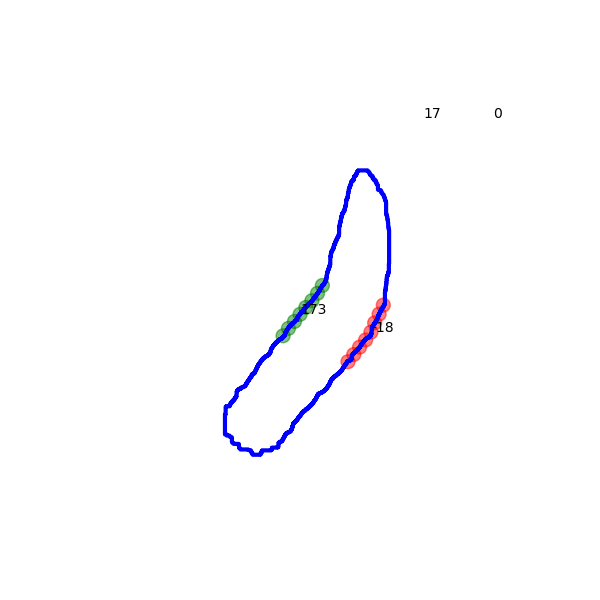

KeyboardInterrupt: 

In [3]:
fig,ax = plt.subplots(1,1, figsize=(6, 6))
ax.set_axis_off()
plt.ion()
all_bend_pts = np.array([])
for idx, data in enumerate(data_to_send_all):
#     in_bend, out_bend, curv = get_bend_points(data['contour'], data['head_index'], data['tail_index'])
    bend_pts, mr = get_bend_points(data['contour'], data['head_index'], data['tail_index'])
    
    if idx == 0:
        all_bend_pts = np.hstack((bend_pts[0, 2], bend_pts[8, 2]))
    else:
        all_bend_pts = np.vstack((all_bend_pts, np.hstack((bend_pts[0, 2], bend_pts[8, 2]))))

    ax.plot(data['contour'][:, 0], data['contour'][:, 1], 'b', lw=3)
    plt.text(bend_pts[3, 0], bend_pts[3, 1], '%d' %(bend_pts[3, 2]))
    plt.text(bend_pts[11, 0], bend_pts[11, 1], '%d' %(bend_pts[11, 2]))
    
    for p in range(0, np.shape(bend_pts[0:8, 0])[0]):
        circ = plt.Circle((bend_pts[p, 0], bend_pts[p, 1]), radius=30, color='r', fill=1, alpha=0.5)
        ax.add_artist(circ)

    for p in range(0, np.shape(bend_pts[8:, 0])[0]):
        circ = plt.Circle((bend_pts[8+p, 0], bend_pts[8+p, 1]), radius=30, color='g', fill=1, alpha=0.5)        
        ax.add_artist(circ)
    
    plt.text(1800, 1800, '%d' %(mr))
    plt.text(1500, 1800, '%d' %(idx))
    
    ax.set_xlim(0, 2000); ax.set_ylim(0, 2000); ax.set_axis_off();
    fig.canvas.draw()
    time.sleep(1)
    ax.clear()


In [ ]:
%timeit -n 1000 f = get_bend_points(data['contour'], data['head_index'], data['tail_index'])

In [ ]:
%load_ext line_profiler
%lprun -f get_bend_points get_bend_points(data['contour'], data['head_index'], data['tail_index'])

In [ ]:
# all_bend_pts
plt.figure()
all_bend_pts[(all_bend_pts >= -5) & (all_bend_pts <= 5)] = 0
all_bend_pts[(all_bend_pts <= -175) | (all_bend_pts >= 175)] = 0
plt.plot(all_bend_pts[:, 0], 'r.-', lw=1)
plt.plot(all_bend_pts[:, 1], 'b.-', lw=1)

In [ ]:
np.shape(all_bend_pts)

In [ ]:
np.shape(bend_pts)